In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice, rand 
from timeit import default_timer as timer
import copy
from itertools import groupby
import sys
import pandas as pd
from collections import defaultdict
from random import choice
from fractions import Fraction

## Problem 1
Let's define the transiction rate matrix

In [2]:
L = np.array([[0, 2/5, 1/5, 0, 0],
                [0, 0, 3/4, 1/4, 0],
                [1/2, 0, 0, 1/2, 0],
                [0, 0, 1/3, 0, 2/3],
                [0, 1/3, 0, 1/3, 0]])

### Exercise 1.A

In order to simulate the movement of the particle we implemented the 2nd approach presented during laboratory sessions:

1) each node  $i$  is equipped with its own Poisson clock with rate  $\omega_i= \sum_j \Lambda_{ij}$ .

2) when you are at node  i  and the clock of that node ticks, you jump to a neighbor  j  with probability  $P_{ij} = \frac{\Lambda_{ij}}{\omega_i}$

In [3]:
#in order to simulate the particle moving in the graph we have to compute the transiction matrix P that describes the
#probability of moving to another node while being in a certain node
w = np.sum(L, axis=1)
w_star = np.max(w)
D = np.diag(w)
P = np.linalg.inv(D) @ L
#we define the possible state of the matrix corrisponding to every node [0,1,2,3,4]
nstates = len(L[0])
#number of possible movement of the particle
n_steps = 100000

6.830647662498923


Text(0.5, 1.0, 'Trajectory for the first 20 jumps')

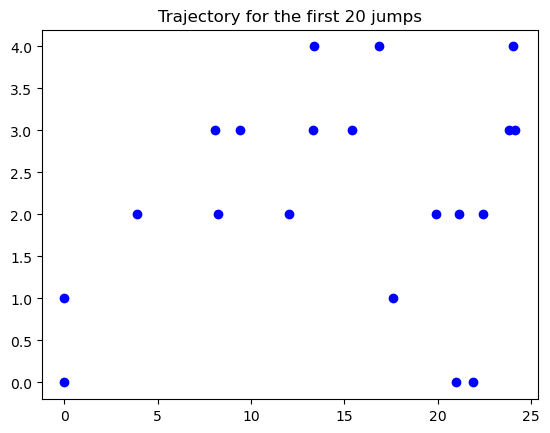

In [4]:
#we initalize the variable used to keep track of the particle movements as well as when it occurs
pos = np.zeros(n_steps, dtype=int)
transition_times = np.zeros(n_steps)
#we define the time of the next movement
t_next = -np.log(np.random.rand())/w[0]
pos[0] = 1
#let's define some memory variables
time_to_a = 0
n_times_in_a = 0
for i in range(2,n_steps):
    #choose the next state randomly according to P
    pos[i] = np.random.choice(nstates, p=P[pos[i-1],:])
    #save total time elapsed from the start of the simulation
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/w[pos[i]]
    #if the particle goes back to state a saves time and increase the number of time the
    #particle returned to a
    if pos[i] == 1:
        n_times_in_a += 1
        time_to_a = transition_times[i]
        
average_time = time_to_a/n_times_in_a
print(average_time)
         

plt.plot(transition_times[0:20], pos[0:20], 'bo')
plt.title('Trajectory for the first 20 jumps')

### Problem 1.B
In order to compute the theoretical return time we must implement the Kac's formula:
\begin{equation}
\mathbb{E}_i[T_i^+] = \frac{1}{\omega_i \overline{\pi}_i}
\end{equation}

where
\begin{equation}
i = a
\end{equation}
 

In [5]:
#first of all we need to compute pi_bar, the stationary distribution of the jump chain
w = np.sum(L, axis=1)
w_star = np.max(w)
Q = L/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

# compute dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


In [6]:
#compute theroretical return time
Rt = 1/((w[1]*pi_bar[1]))
print("the theoretical return time is:", Rt)

the theoretical return time is: 6.750000000000004


### Problem 1.C

In order to simulate the expected hitting from o to d time we use the same method of the exercise 1.a plus a boolean varible helping us to keep track of when it occurs for the first time to the particle to be in o after passing through d and vice-versa

The simulated hitting time is = 8.724958449735627


Text(0.5, 1.0, 'Trajectory for the first 20 jumps')

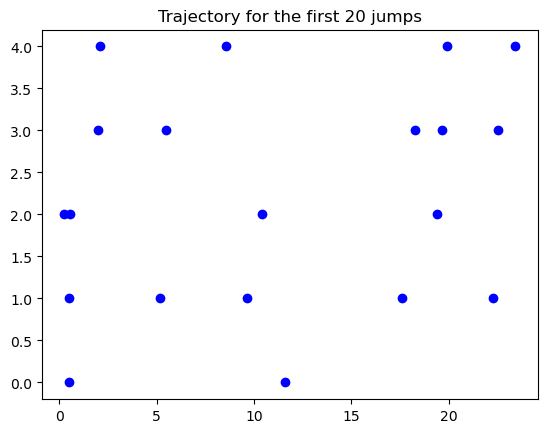

In [7]:
#we initalize the variable used to keep track of the particle movements as well as when the occur
n_steps = 100000
pos = np.zeros(n_steps, dtype=int)
#we define the time of the next movement
transition_times = np.zeros(n_steps)
t_next = -np.log(np.random.rand())/w[0]
#we set this variable to False at first as the particle has never benn in o yet
been_in_o = False
arrive_time = []
for i in range(0,n_steps):
    #choose the next state randomly according to P
    pos[i] = np.random.choice(nstates, p=P[pos[i-1],:])
    #save total time elapsed from the start of the simulation
    transition_times[i] = transition_times[i-1] + t_next 
    t_next = -np.log(np.random.rand())/w[pos[i]]
    #if the particle has not been in o since the last d AND is in o we can start to count the time
    #that it will take for the pareticle to arrive to d (we use the variable start_time for this)
    if pos[i] == 0 and not been_in_o:
        been_in_o = True
        start_time = transition_times[i]
    #if the particle has been in o AND is in d we can stop to count the time
    if pos[i] == 4 and been_in_o:
        been_in_o = False
        #the last transition_times minus start_time is the time hitting time 
        arrive_time.append(transition_times[i] - start_time)


        
average_time = sum(arrive_time)/len(arrive_time)
print("The simulated hitting time is =", average_time)
         

plt.plot(transition_times[0:20], pos[0:20], 'bo')
plt.title('Trajectory for the first 20 jumps')

### Problem 1.D


in order to obtain the theoretiacal hitting time we solve the linear system:
\begin{equation}
   (\mathbb{I} - \hat{P})v = \frac{\mathbb{1}}{\hat{\omega}}.
\end{equation}

which has the solution:

\begin{equation}
    v_o = \mathbb{E}_o[T_d] = \frac{1}{\omega_o} + \sum_{j \in \mathcal{R}} \hat{P}_{oj} \mathbb{E}_j[T_d],
\end{equation}

where $R$ is the set of vertexes that are not d



In [8]:
P_cap = np.delete(P, 4, 1)
P_cap = np.delete(P_cap, 4, 0)

In [9]:
I1 =  np.ones(4)
I = np.diag(np.ones(4))
w_cap = w[0:4]
v = np.linalg.inv(I-P_cap)@(I1/w_cap)
print("The theoretical hitting time is =", v[0])

The theoretical hitting time is = 8.785714285714285


### Problem 1.E

To simulate the averaging of the opinions we multiplied initial opinion by the P matrix 100000 times

In [10]:
t = 0
n_steps = 100000
cont_n_convergence = 0
rng = np.random.default_rng()
random_array = rng.integers(100, size=5)*np.random.rand(5)
x0e = np.random.rand(5)*random_array #initial condition
x = x0e
for i in range(0, n_steps):
    x = P @ x
    t=t+1

print("Initial opinions =",x0e)
print("Simulation Values obtained by applying the French-De Groot dynamics ==", x) 

Initial opinions = [35.29438897  1.84482566  0.91102884  8.89465495  1.09323801]
Simulation Values obtained by applying the French-De Groot dynamics == [7.67258801 7.67258801 7.67258801 7.67258801 7.67258801]


According to the theory, given aperiodicy and strong connectivity, we should have that:

$$
\lim_{t \to +\infty} x(t) = \alpha \mathbf{1},
$$

where 

$$
\alpha = \overline{\pi} x(0)
$$

and where $\overline{\pi}$ is the unique invariant distribution of P

In [11]:
#compute pi
w,v = np.linalg.eig(P.T)
# selects the eigenvalue 1 and print the eigenvector
for index in [i for i in range(nstates) if np.isclose(w[i],1)]: 
    pi = v[:,index].real
    pi = pi/np.sum(pi)
    
#we implement the formulas above defining the vector 1
I1 =  np.ones(5)
alpha = pi*x
value_consensus = alpha@I1
print("The theoretical consensus value is", value_consensus)

The theoretical consensus value is 7.672588012425446


### Problem 1.F


In [12]:
rng = np.random.default_rng()
random_array = rng.integers(100)*np.random.rand()
b = np.random.rand()*random_array 
a=0
var = (1/12)*np.power((a-b),2)
mu = 1/2*(a+b)
n_steps = 1200
differences = np.zeros(n_steps)
errors = np.zeros(1200) 
#we simulate 1200 times the variance
for i in range(n_steps): 
  #initial condition
    x0 = np.random.uniform(a,b,5)
    x = x0
  #we compute each variance with a simulation of 500 steps
    for e in range(500):
     x = P@x
  #we get the squared differences between the value it converged to and the true value mu.
    errors[i] = (np.mean(x) - mu)**2 

print("Theoretical variance of the consensus value =", var*np.sum(np.power(pi,2)))
print("Variance of the consensus value obtained =", np.mean(errors))

Theoretical variance of the consensus value = 0.9721053724464767
Variance of the consensus value obtained = 1.0920265993234648


### Problem 1.G

In [13]:
Lambda = np.array([[0,2/5,1/5,0,0],[0,0,3/4,1/4,0],[1/2,0,0,1/2,0],[0,0,1/3,0,2/3], 
                 [0,1/3,0,1/3,0]])

In [14]:
def removeEdge(node1,node2,Lambda): #method to remove an edge between node1 and node2 from the rate matrix Lambda
    Lambda[node1,node2] = 0
    return Lambda

In [15]:
Lambda_g = Lambda.copy() 
Lambda_g = removeEdge(4,1,Lambda_g) #to remove edge (d,a)
Lambda_g = removeEdge(4,3,Lambda_g) #to remove edge (d,c)
Lambda_g[4,4] = 1 #to apply the French-De Groot dynamics it is necessary to add a selfloop to node d, in order also to obtain matrix P_g
Lambda_g
w_g = np.sum(Lambda_g,axis=1)
D_g = np.diag(w_g)
P_g =np.linalg.inv(D_g) @ Lambda_g
nstates = len(w_g)
print(nstates)
Lambda_g

5


array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [16]:
np.set_printoptions()
rng = np.random.default_rng()
random_array = rng.integers(100, size=5)*np.random.rand(5) #to obtain a random array 
x0g = np.random.rand(5)*random_array #to obtain the initial state
xg = x0g # set the initial opinion
for i in range(10000): #cycle for to simulate the French-De Groot dynamics
    xg=P_g@xg 

eigenvalues,eigenvectors = np.linalg.eig(P_g.T)
for i in [j for j in range(nstates) if np.isclose(eigenvalues[j],1)]: #cycle for to compute the vector pi
    pi = eigenvectors[:,i].real
    pi = pi/np.sum(pi)
    print("pi = ",pi)

consensusValue = pi@x0g 
print("Initial opinions =",x0g)
print("Theoretical consensus Value =", consensusValue)
print("Simulation Values obtained by applying the French-De Groot dynamics =", xg)

pi =  [0. 0. 0. 0. 1.]
Initial opinions = [15.14509978  9.68820991 25.70310259 14.18340437 28.09968419]
Theoretical consensus Value = 28.099684194882297
Simulation Values obtained by applying the French-De Groot dynamics = [28.09968419 28.09968419 28.09968419 28.09968419 28.09968419]


In [17]:
rng = np.random.default_rng()
random_array = rng.integers(100)*np.random.rand()
b = np.random.rand()*random_array #b is the upper limit of the uniform distribution. It is obtained randomly
a=0 #a is the lower bound of the uniform distribution. It is set equal to 0
var = (1/12)*np.power((a-b),2) #formula to obtain the variance of the uniform distribution
mu = 1/2*(a+b) #formula to obtain the mean mu of the uniform distribution
errors = np.zeros(1200) 
for i in range(1200):
    x0 = np.random.uniform(a,b,5) #in this way it is possible to obtain a vector of 5 random point that belong to an uniform distribution whose
                                  #bounds are computed before
    x = x0
    for j in range(500): #cycle for to simulate the French-De Groot dynamics
        x = P_g@x
    errors[i] = (np.mean(x)-mu)**2 #errors defined as the quadratic errors


print("Theoretical variance of the consensus value =", var*np.sum(np.power(pi,2)))
print("Variance of the consensus value obtained =" ,np.mean(errors))

Theoretical variance of the consensus value = 4.7140227996230415
Variance of the consensus value obtained = 4.824034550063136


### Problem 1.H

In [18]:
Lambda_h = Lambda.copy()
Lambda_h = removeEdge(3,2,Lambda) #to remove edge (c,b)
Lambda_h = removeEdge(4,1,Lambda) #to remove edge (d,a)
#in this case it is not necessary to add a selfloop
w_h = np.sum(Lambda_h, axis=1)
D_h = np.diag(w_h)
P_h = np.linalg.inv(D_h) @ Lambda_h
nstates = len(w_h)
print(Lambda_h)

[[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         0.66666667]
 [0.         0.         0.         0.33333333 0.        ]]


In [19]:
rng = np.random.default_rng()
random_array = rng.integers(100, size=5)*np.random.rand(5)  #to obtain a random array 
x0h = np.random.rand(5)*random_array #to obtain the initial state
xh = x0h #set the initial opinion
for n in range(500): #cycle for to simulate the French-De Groot dynamics
    xh = P_h @ xh
print(xh)



[38.66890595 40.26405468 25.90771613 57.8106907  16.33682375]


In [20]:
eigenvalues,eigenvectors = np.linalg.eig(P_h.T)
for i in [j for j in range(nstates) if np.isclose(eigenvalues[j],1)]: #cycle for to compute the vector pi
    pih = eigenvectors[:,i].real
    pih = pi/np.sum(pih)
    print("pi = ",pih)
consensusValue = pih@x0h
print("Consensus Value =", consensusValue)
print("Simulation Values obtained by applying the French-De Groot dynamics =", xh)
print("Simulation Values should converge to the Consensus Value. By the result obtained, we can say they do NOT converge.")

pi =  [0.         0.         0.         0.         0.70710678]
Consensus Value = 11.551878860125093
Simulation Values obtained by applying the French-De Groot dynamics = [38.66890595 40.26405468 25.90771613 57.8106907  16.33682375]
Simulation Values should converge to the Consensus Value. By the result obtained, we can say they do NOT converge.


In [21]:
rng = np.random.default_rng()
random_array = rng.integers(100)*np.random.rand()  #to obtain a random array 
b = np.random.rand()*random_array  #b is the upper limit of the uniform distribution. It is obtained randomly
a=0 #a is the lower bound of the uniform distribution. It is set equal to 0
var = (1/12)*np.power((a-b),2)  #formula to obtain the variance of the uniform distribution
mu = 1/2*(a+b) #formula to obtain the mean mu of the uniform distribution
errors = np.zeros(1200)
for i in range(1200):
    x0 = np.random.uniform(a,b,5) #in this way it is possible to obtain a vector of 5 random point that belong to an uniform distribution whose
                                  #bounds are computed before
    x = x0
    for j in range(500):  #cycle for to simulate the French-De Groot dynamics
        x = P_h@x
    errors[i] = (np.mean(x)-mu)**2 #errors defined as the quadratic errors

print("Theoretical variance of the consensus value =", var*np.sum(np.power(pih,2)))
print("Variance of the consensus value obtained =" ,np.mean(errors))

Theoretical variance of the consensus value = 0.012346725447455327
Variance of the consensus value obtained = 0.011776102905159744


## Problem 2

### Problem 2.A

In [22]:
Lambda = np.array([[0,2/5,1/5,0,0],[0,0,3/4,1/4,0],[1/2,0,0,1/2,0],[0,0,1/3,0,2/3], 
                 [0,1/3,0,1/3,0]])  
w = np.sum(Lambda, axis=1)
D = np.diag(w)
P = np.linalg.inv(D)@Lambda
nstates = len(w)
w_star = np.max(w)
P_bar = Lambda/w_star
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1)) #P_bar plus the diagonal matrix

values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar) #to obtain p_bar
P_bar

array([[0.4       , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.33333333]])

In [23]:
def getAverageTime(node1,simulations): #method to compute the average time for 100 particles starting from node1 to return to node1
    tot_time = 0 #total time initialized to 0
    
    for i in range(simulations):
        number = 0 #it indicates how many particles returned to node 1
        positions = node1*np.ones(100,dtype=np.int32) #to initialize the positions at the beginning of each simulation
        movements = np.zeros(100) #initialized to 0, it indicates which particles are moving (at the end its values are all ones)
        return_times = np.zeros(100) #return times initialized to 0 (at the beginning of a simulation, particles are in node1)            
        cum_time = 0 #cumulative time 
        while number<100: #while the number of particles returned to node1 is less than 100, the cycle is iterated
            t_next = -np.log(np.random.rand())/100 #Poisson clock
            cum_time = cum_time + t_next #add to the cumulative time the Poisson clock
            pos = np.random.randint(0,100)
            positions[pos] = np.random.choice(np.arange(nstates), p = P_bar[positions[pos]]) #to randomly select a new position
            if movements[pos] == 0 and positions[pos] != node1 : #particle is moving, but not in node a
                movements[pos] = 1
            if movements[pos] == 1 and positions[pos] == node1 and return_times[pos] == 0: #particle returned to node a
                return_times[pos] = cum_time
                number +=1
            
        avg_time=np.average(return_times)
        tot_time = tot_time + avg_time
    
    print("The average time is =",tot_time/simulations)

In [24]:
getAverageTime(1,1000)

The average time is = 6.7690641054820055


### Problem 2.B

In [25]:
def getNumberParticlesPlot(node1,simulations): #method to compute the average number of particles, starting in node1 in the different
                                               #nodes at the end of the simulation
    pos_plot = 0 #variable needed to select the elements to plot
    t_times = np.zeros(10000) #times to plot
    particles_time = np.zeros((5,10000), dtype=np.int32) #number of particles in each node for each time 
    tot_particles = np.zeros(5,dtype=np.int32) #the total number of particles in each node at the end of the simulations
    
    for i in range(simulations):
        particles = np.zeros(5, dtype=np.int32) #number of particles in each node
        particles[node1] = 100 #at the beginning of the simulation, particles are all in node1
        tot_time = 0
    
        while tot_time<60: #if total time units are less than 60, the cycle is iterated
            if i==0: #to plot the values related to the first simulation
                particles_time[:,pos_plot] = particles #to select the number of particles in each node until pos_plot
            t_next = -np.log(np.random.rand())/100 #Poisson clock
            tot_time += t_next #add the Poisson Clock to the total time
            if i==0: #to plot the values realted only to the first simulation
                t_times[pos_plot] = tot_time #consider time at pos_plot
                pos_plot += 1 #to update pos_plot
            source_node = np.random.choice(np.arange(nstates),p=particles/np.sum(particles)) #node from which to move in relation to the number of particles
            next_node = np.random.choice(np.arange(nstates), p=P_bar[source_node]) #node to which to move
            particles[source_node] -=1 #from source node a particle goes away
            particles[next_node] +=1 #to next node a particle arrives
       
            
        tot_particles = tot_particles + particles #the total number of particles is updated
    print("The average number of particles is =",tot_particles/simulations)
    fig,ax = plt.subplots(figsize=(8,8))
    vertices_names = {0:'o',1:'a',2:'b',3:'c',4:'d'} #to rename the vertices with their names
    for i in range(nstates):

        v = str(vertices_names[i])
        lab = 'node ' + str(v)
        ax.plot(t_times[:pos_plot], particles_time[i,:pos_plot], label=lab) #to plot times and particles of node v
        ax.legend(fontsize=8)
       
        ax.set_xlabel('Time units', fontsize=10)
        ax.set_ylabel('Number of particles',fontsize=10)
        plt.savefig("ex2B.pdf")
    return tot_particles/simulations

The average number of particles is = [18.651 14.819 22.19  22.036 22.304]


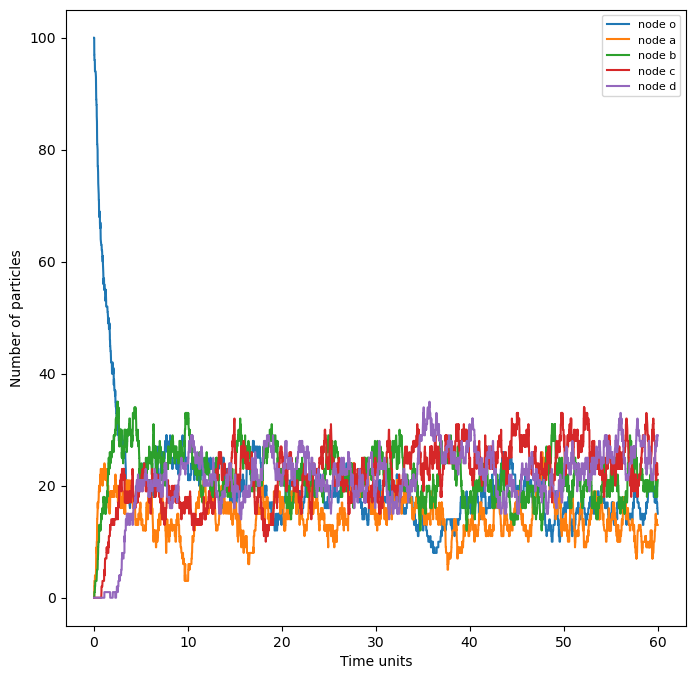

In [26]:
avgParticles = getNumberParticlesPlot(0,1000)

In [27]:
singular = (avgParticles)/np.sum(avgParticles) #to compare with pi_bar
print(singular)
print(pi_bar)
print('The differences between the two results obtained is =', abs(singular-pi_bar))

[0.18651 0.14819 0.2219  0.22036 0.22304]
[0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]
The differences between the two results obtained is = [1.32481481e-03 4.18518519e-05 3.22222222e-04 1.86222222e-03
 8.17777778e-04]


In [28]:
np.set_printoptions(formatter={'all':lambda x: str(Fraction(x).limit_denominator())})

## Problem 3

Let $\omega = Λ1$.

In [29]:
Lambda_open = np.array([[0,  3/4, 3/8, 0,   0],
               [0,  0,   1/4, 1/4, 2/4],
               [0,  0,   0,   1,   0],
               [0,  0,   0,   0,   1],
               [0,  0,   0,   0,   0]])
w = np.dot(Lambda_open, np.ones(5))
w

array([9/8, 1, 1, 1, 0])

{('o', 'a'): Text(0.5, 1.0, '3/4'),
 ('o', 'b'): Text(0.5, -1.0, '3/8'),
 ('a', 'b'): Text(1.0, 0.0, '1/4'),
 ('a', 'c'): Text(1.5, 0.0, '1/4'),
 ('a', 'd'): Text(1.5, 2.0, '1/2'),
 ('b', 'c'): Text(1.5, -2.0, '1'),
 ('c', 'd'): Text(2.0, 0.0, '1')}

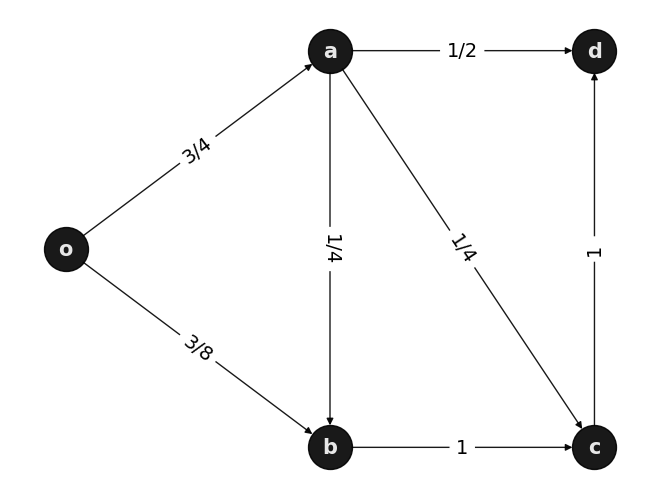

In [30]:
G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d'])
G.add_weighted_edges_from([('o', 'a', 3/4), ('o', 'b', 3/8), ('a', 'b', 1/4),
                           ('a', 'c', 1/4), ('a', 'd', 2/4), ('b', 'c', 1),
                           ('c','d', 1)])

pos = {'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,-2),'d':(2,2)}
nx.draw(G, pos, with_labels = True, node_size=1000, node_color='black',
        font_color='white', font_weight='bold', font_size=15, alpha=0.9)
labels = {e : Fraction(G.edges[e]['weight']) for e in G.edges} # 'edge' : 'weight'
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='black', font_size=14)

For nodes $i$ such that $\omega_i=0$ (which means that once the process in $i$ it remains $i$ forever), we need to add a selfloop $\Lambda_{ii}>0$, otherwise the matrix $P$ is not well defined (it would mean dividing the matrix P by 0). Since node $d$ does not have a node to send its particles to, we can proceed equivalently in one of these two following ways:
1. assume that $\omega_{d} = 2$;
2. (what we implemented) think of another node $d'$ connected to node $d$, such that at every tick of the Poisson clock of $d$, it sends a particle to node $d'$: $w_d=1,\ w_{d'}=1$.

For this system, particles will enter the system at node $o$ according to a Poisson process with input rate $\lambda = 1$. In order to simulate the entrance of the particles in the system, we create a new node $o'$ connected to $o$ such that the rate for its associated Poisson clock equals the input rate: $\omega_{o'} = \lambda$. Note that the number of particles inside the source $o'$ equals the input rate at every time instant.

In [31]:
Lambda_augmented = np.zeros((7,7)) # we add node o' as the start node at index=0
Lambda_augmented[1:6, 1:6] = Lambda_open
Lambda_augmented[0,1] = 1 # o --> o'
Lambda_augmented[5,6] = 1 # d self loop
Lambda_augmented[6,5] = 1 # d self loop
print(Lambda_augmented)

[[0 1 0 0 0 0 0]
 [0 0 3/4 3/8 0 0 0]
 [0 0 0 1/4 1/4 1/2 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


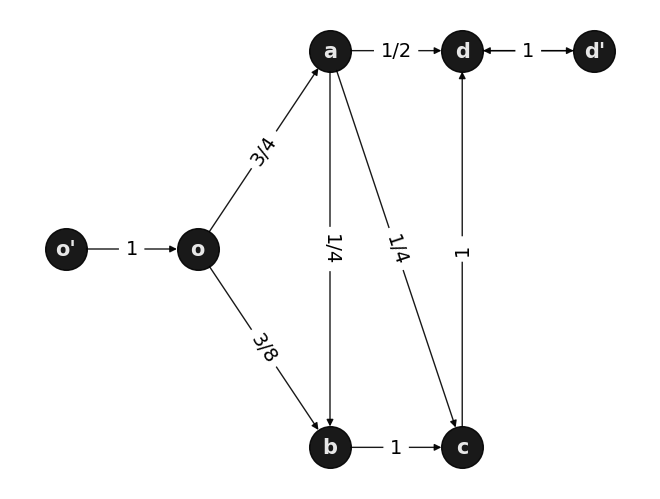

In [32]:
G = nx.DiGraph()
G.add_nodes_from(["o'",'o','a','b','c','d', "d'"])
G.add_weighted_edges_from([('o', 'a', 3/4), ('o', 'b', 3/8), ('a', 'b', 1/4),
                           ('a', 'c', 1/4), ('a', 'd', 2/4), ('b', 'c', 1),
                           ('c','d', 1), ('d', "d'", 1), ("d'", "d", 1), ("o'", 'o', 1)])

pos = {"o'": (-1,0), 'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,-2),'d':(2,2), "d'":(3,2)}
nx.draw(G, pos, with_labels = True, node_size=900, node_color='black',
        font_color='white', font_weight='bold', font_size=15, alpha=0.9)
labels = {e : Fraction(G.edges[e]['weight']) for e in G.edges} # 'edge' : 'weight'
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='black', font_size=14)
plt.savefig("Lambda.pdf")

In [33]:
w = np.dot(Lambda_augmented, np.ones(7))
D = np.diag(w)
P = np.dot(np.linalg.inv(D), Lambda_augmented)
print("Matrix w\n",w,"\n")
print("Matrix D\n",D,"\n")
print("Matrix P\n",P,"\n")

Matrix w
 [1 9/8 1 1 1 1 1] 

Matrix D
 [[1 0 0 0 0 0 0]
 [0 9/8 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]] 

Matrix P
 [[0 1 0 0 0 0 0]
 [0 0 2/3 1/3 0 0 0]
 [0 0 0 1/4 1/4 1/2 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]] 



In [34]:
def simulation(max_time, input_rate, fixed):
    # for each tick of Poisson clock, save the number of particles of all the nodes
    nodes_ticks_particles = defaultdict(lambda:[])
    # n.of particles in each node registered after the last update
    # init: 0 particles in every node, except node o' = input_rate
    num_particles = defaultdict(lambda: 0)
    num_particles[0] = input_rate
    # tick of Poisson clock for each node measured after the last update
    t_tick = defaultdict(lambda: 0) # init: our study starts from time=0 in all the nodes
    # node_i's waiting random time for next transition, according to its distribution defined by num_particles[i]*w[i]
    # init: since all the nodes, except o', are without particles, waiting time in every node is set to inf
    t_next = defaultdict(lambda: np.inf)
    if not fixed:
        t_next[0] = -np.log(np.random.rand())/(num_particles[0]*w[0])
    else:
        t_next[0] = -np.log(np.random.rand())/input_rate
    # init: time instant of the last update set to -1 in order to avoid its effect at the beginning of the simulation
    last_update_time = -1

    # while there is at least one valid scheduled transition time,
    # i.e. among the next transitions for all the nodes, there exists >= 1 whose time instant is before the max_time
    # Note: do not consider the scheduled transition time for "d" since it sends its particles only to a fictitious node
    while (t_tick[0] + t_next[0] <= max_time or
           t_tick[1] + t_next[1] <= max_time or
           t_tick[2] + t_next[2] <= max_time or
           t_tick[3] + t_next[3] <= max_time or
           t_tick[4] + t_next[4] <= max_time):

        # minimum scheduled time for next transition: related to the node that will update before the other ones
        t_min = max_time # init: = max possible value
        # find the nodes having the smallest t_min, i.e. the nodes which have the transition before the other ones
        # Note: at the same time instant, there could exist more than one node updating its number of particles
        for node in range(0,6): # (o',o,a,b,c,d)
            # consider only the nodes with some particles: the nodes without particles cannot update
            if num_particles[node] > 0:
                # a node can have its next update scheduled before the last global update,
                # due to the fact that at its scheduled time it had no particles inside,
                # i.e. that node did not enter into this 'if' at its scheduled time, so t_tick wasn't updated
                while t_tick[node] + t_next[node] < last_update_time:
                    # we postpone the update s.t. it is >= last_update_time
                    t_tick[node] += t_next[node]
                    if not fixed:
                        t_next[node] = -np.log(np.random.rand())/(num_particles[node]*w[node]) # for next transition
                    else:
                        if node==0:
                            t_next[node] = -np.log(np.random.rand())/input_rate # for next transition
                        else:
                            t_next[node] = -np.log(np.random.rand())/w[node]
                # find the minimum scheduled time for next transition among all the nodes
                if t_tick[node] + t_next[node] < t_min:
                    t_min = t_tick[node] + t_next[node]

        nodes_to_update = [] # contains the nodes s.t. their scheduled time = the first time available for next jump
        for node in range(0,7): # (o',o,a,b,c,d,d')
            if num_particles[node] > 0: # if the node has some particles
                if t_tick[node] + t_next[node] == t_min: # take only the nodes with the lowest t_min
                    nodes_to_update.append(node)

        last_update_time = t_min # update the instant time of the last update

        # update the number of particles in those nodes
        for node in nodes_to_update:
            t_tick[node] += t_next[node] # local clock time augmented of the waiting time for a new update
            # When the Poisson clock ticks for this node, we decrease the number of particles in the node by 1
            # (if there are any particles in the node).
            # Note: do not update o' because it is the source, fictitious node: its capacity is inf
            if node != 0 and num_particles[node] > 0:
                num_particles[node] -= 1

            # random choice (according to P distribution) of where the particle will go from the considered node
            out_node = np.random.choice(7, p=P[node,:])

            # do not increment number of particles if node is d' because it is like a self-loop in d
            if out_node != 6:
                # store the new number of particles for the dst nodes
                num_particles[out_node] += 1 # 1 particle added in out_node
                # store the new Poisson clock times for the dst nodes
                # Note: times are equal because the update happens at the same time instant in both src and dst
                if np.isinf(t_next[out_node]):
                    # happens if t_next[node=out_node] was set to inf, bc num_particles[node=out_node]=0
                    # Note: see the 'else' block below
                    if not fixed:
                        t_next[out_node] = -np.log(np.random.rand())/(num_particles[out_node]*w[out_node])
                    else:
                        t_next[out_node] = -np.log(np.random.rand())/w[out_node]

            temp_list = [num_particles[i] for i in range(1,6)]
            nodes_ticks_particles[t_tick[node]] = temp_list

            if num_particles[node] > 0:
                if not fixed:
                    t_next[node] = -np.log(np.random.rand())/(num_particles[node]*w[node])
                else:
                    if node == 0:
                        t_next[node] = -np.log(np.random.rand())/input_rate
                    else:
                        t_next[node] = -np.log(np.random.rand())/w[node]
            else:
                # if there are no particles in node, node's waiting random time for the next transition is set to inf
                t_next[node] = np.inf

    return nodes_ticks_particles

In [35]:
def evolution_times_particles(nodes_ticks_particles):
    times = []
    nodes_particles_dict = defaultdict(lambda:[])
    for t,p in nodes_ticks_particles.items():
        times.append(t)
        nodes_particles_dict['o'].append(p[0])
        nodes_particles_dict['a'].append(p[1])
        nodes_particles_dict['b'].append(p[2])
        nodes_particles_dict['c'].append(p[3])
        nodes_particles_dict['d'].append(p[4])
    return times, nodes_particles_dict

In [36]:
# evolution of n.of particles and Poisson clock ticks visualized in graph
def plot_evolution(input_rate, times, nodes_particles_dict, fixed):
    if not fixed:
        strg = "3a_"
    else:
        strg = "3b_"
    plt.figure(figsize=(7,7))
    plt.xlabel("Time units")
    plt.ylabel("Number of particles")
    for node, color in zip(nodes_particles_dict.keys(),
                           ["tab:orange","tab:blue","tab:red","tab:green","tab:purple"]):
        lab = 'node ' + str(node)
        plt.plot(times, nodes_particles_dict[node], label=lab, color=color)
    plt.legend()
    plt.savefig(strg+str(input_rate)+".pdf")

### Problem 3.A
Each node $i$ will pass along particles according to a Poisson process with rate equal to the number of particles in the node times the rate of the local Poisson clock of node i, i.e., the node $i$ will pass along particles with rate $\omega_{i}N_{i}(t)$.

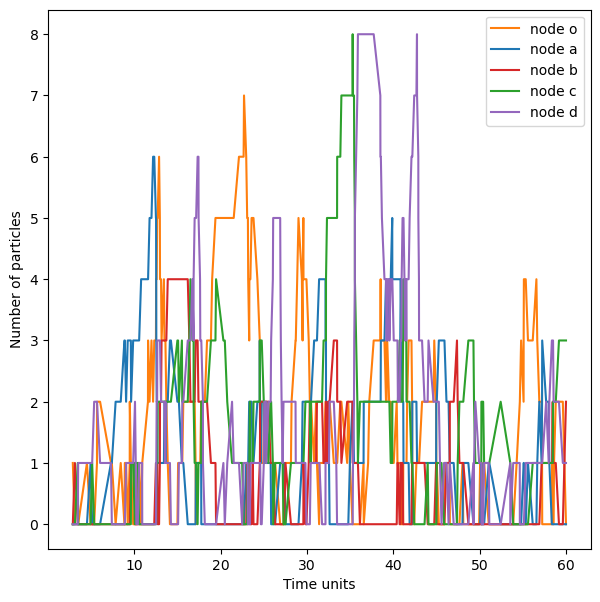

In [37]:
# 3a.1
nodes_ticks_particles = simulation(max_time=60, input_rate=1, fixed=False)
times, nodes_particles_dict = evolution_times_particles(nodes_ticks_particles)
plot_evolution(input_rate=1, times=times, nodes_particles_dict=nodes_particles_dict, fixed=False)

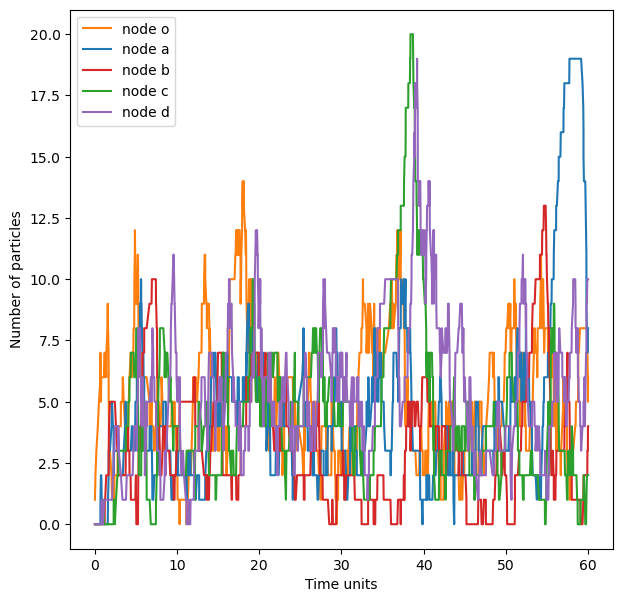

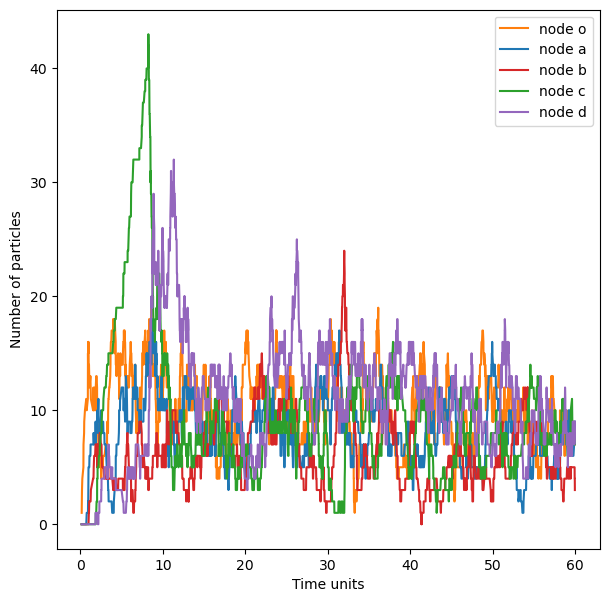

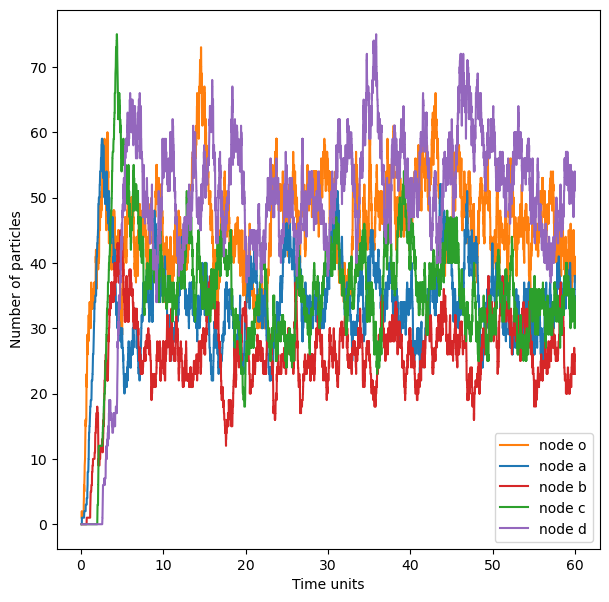

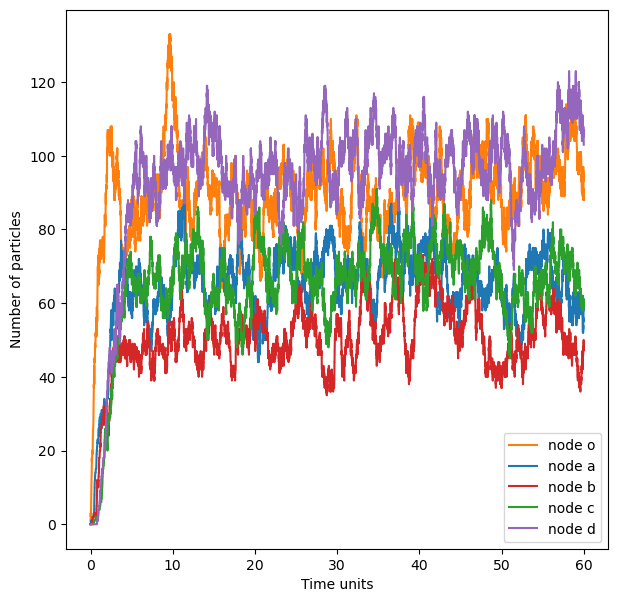

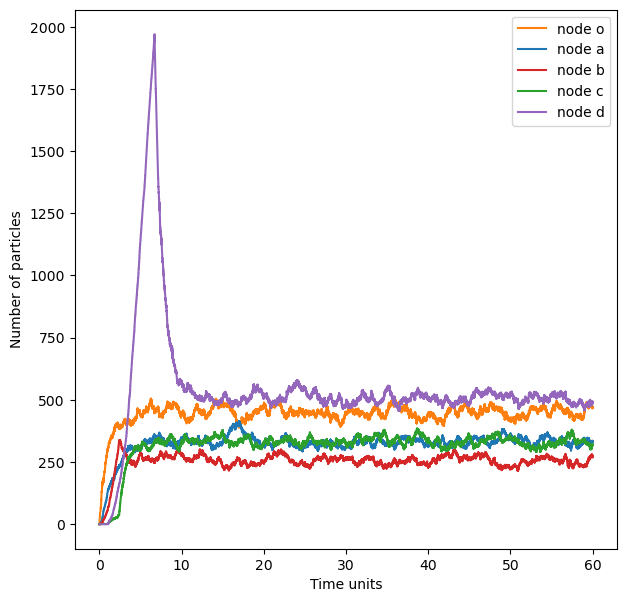

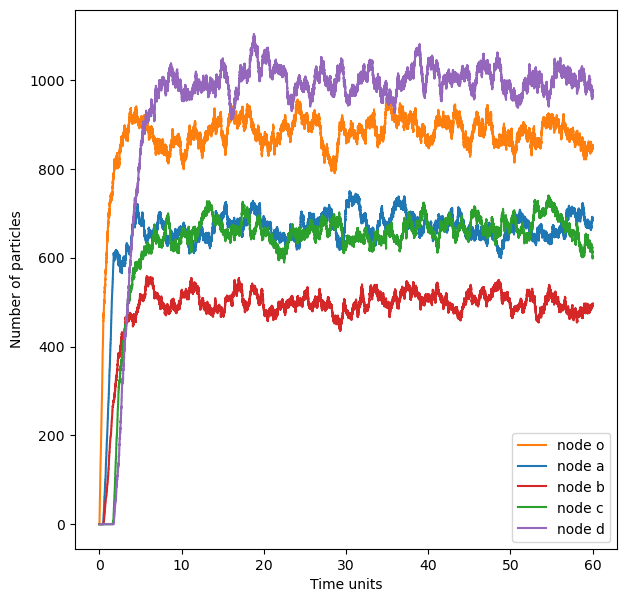

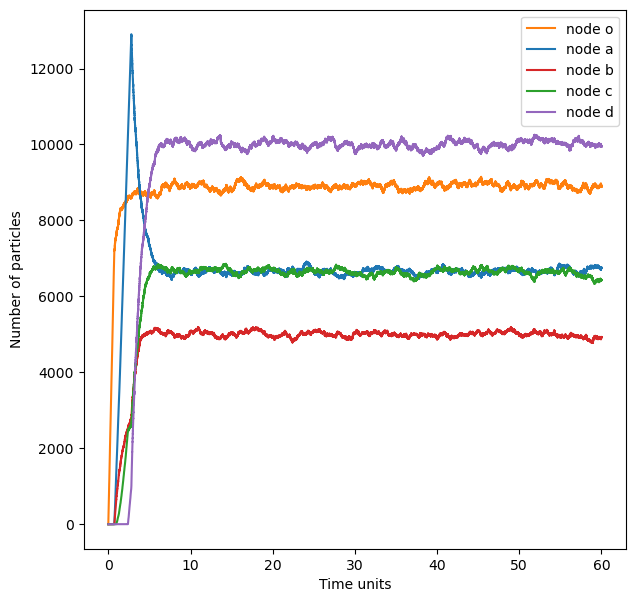

In [38]:
# 3a.2
for ir in [5, 10, 50, 100, 500, 1000, 10000]:
    nodes_ticks_particles = simulation(max_time=60, input_rate=ir, fixed=False)
    times, nodes_particles_dict = evolution_times_particles(nodes_ticks_particles)
    plot_evolution(input_rate=ir, times=times, nodes_particles_dict=nodes_particles_dict, fixed=False)

### Problem 3.B
Each node $i$ will pass along particles with a fixed rate $\omega$.

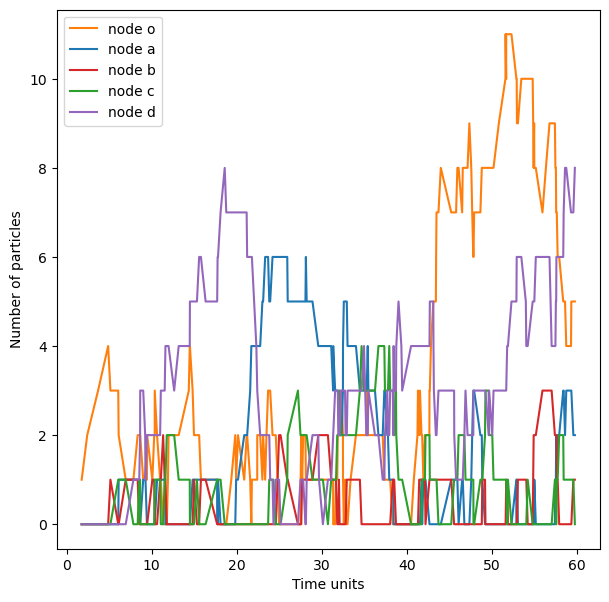

In [39]:
# 3b.1
nodes_ticks_particles = simulation(max_time=60, input_rate=1, fixed=True)
times, nodes_particles_dict = evolution_times_particles(nodes_ticks_particles)
plot_evolution(input_rate=1, times=times, nodes_particles_dict=nodes_particles_dict, fixed=True)

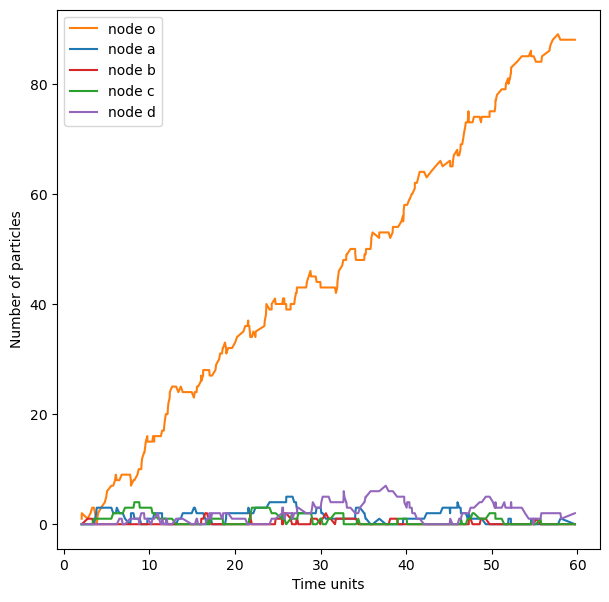

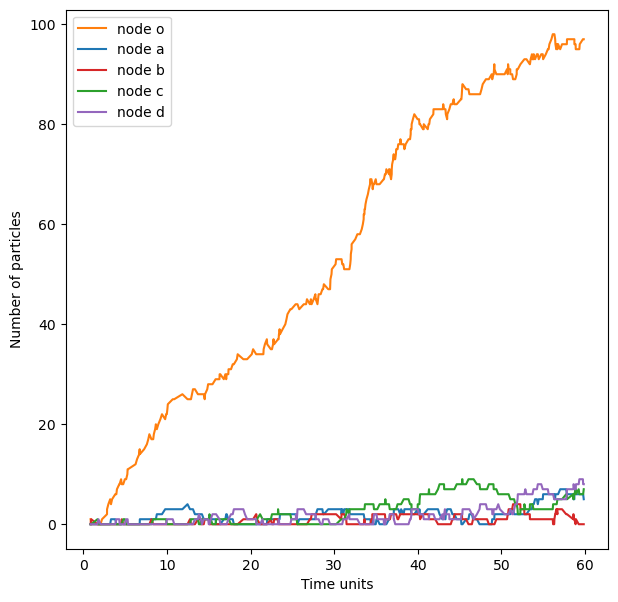

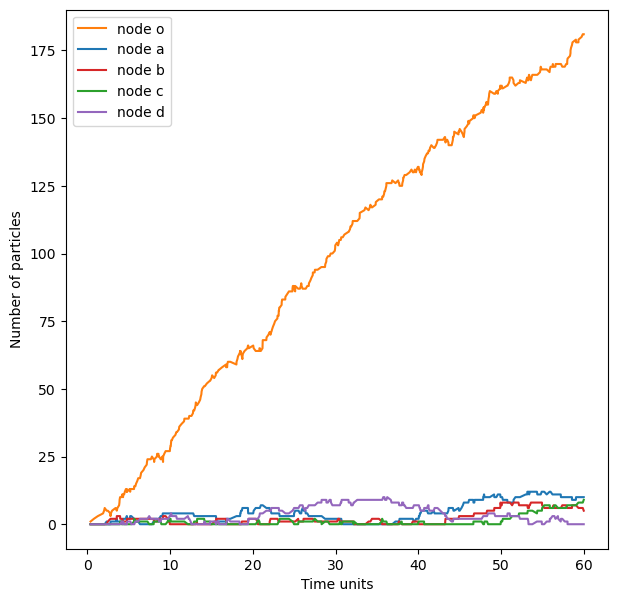

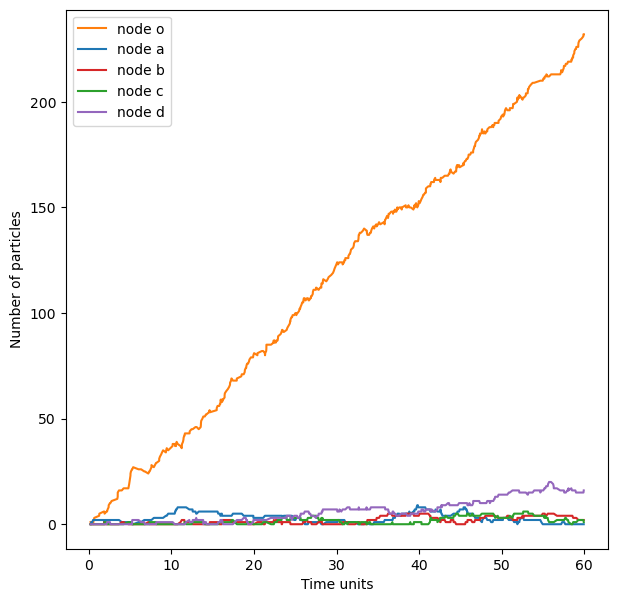

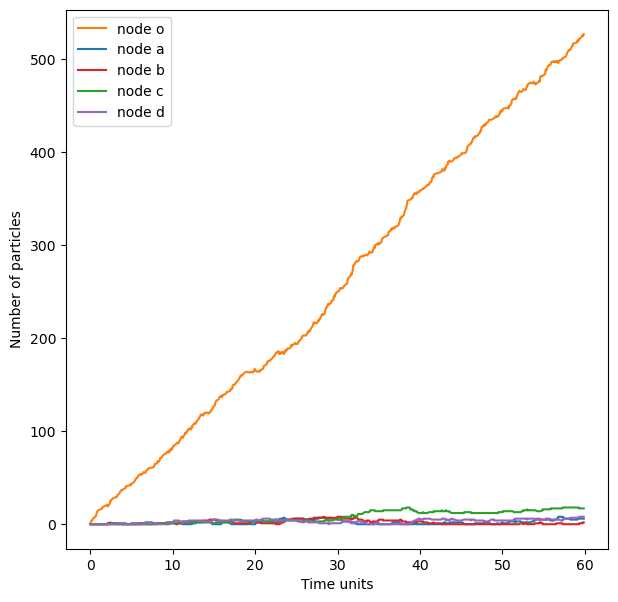

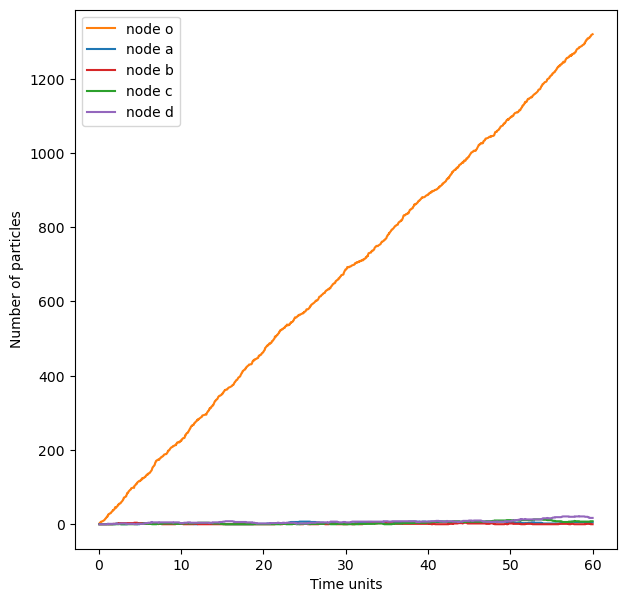

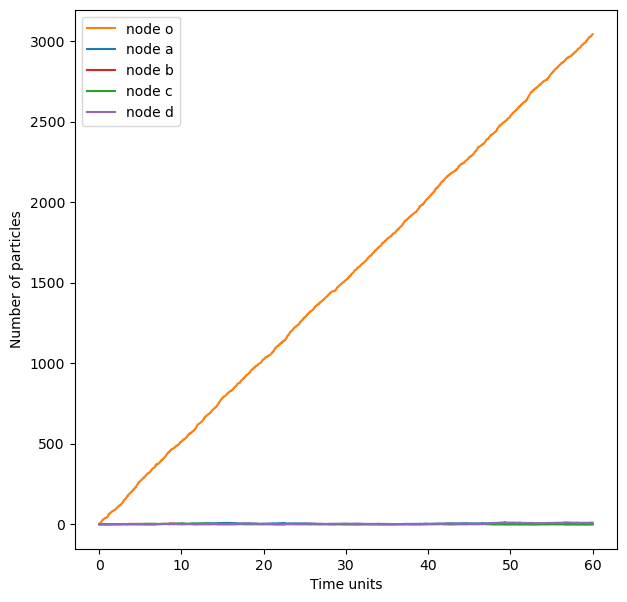

In [40]:
# 3b.2
for ir in [2, 3, 4, 5, 10, 25, 50]:
    nodes_ticks_particles = simulation(max_time=60, input_rate=ir, fixed=True)
    times, nodes_particles_dict = evolution_times_particles(nodes_ticks_particles)
    plot_evolution(input_rate=ir, times=times, nodes_particles_dict=nodes_particles_dict, fixed=True)